In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

2022-08-16 11:13:42.250616: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-16 11:13:42.250653: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv('../DATA/Frozen_Dessert_Production.csv', parse_dates=True, index_col='DATE')

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [5]:
df.columns = ['Production']

In [6]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


<AxesSubplot:xlabel='DATE'>

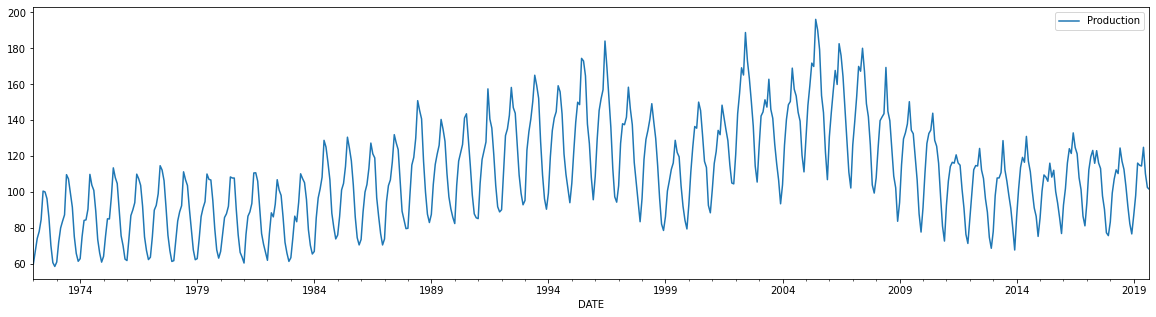

In [7]:
df.plot(figsize=(20,5))

In [9]:
test = df.iloc[-24:]

In [10]:
train = df.iloc[:-24]

In [11]:
len(test)

24

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler  = MinMaxScaler()

In [14]:
scaler.fit(train)

MinMaxScaler()

In [15]:
scaled_train =  scaler.transform(train)

In [16]:
scaled_test =  scaler.transform(test)

In [17]:
generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train, length=24, batch_size=1)

In [18]:
X, y = generator[0]

In [19]:
y

array([[0.03141355]])

In [20]:
model = Sequential()

2022-08-16 11:14:10.393498: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-16 11:14:10.393526: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-16 11:14:10.393581: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cruzai-VirtualBox): /proc/driver/nvidia/version does not exist
2022-08-16 11:14:10.394696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model.add(LSTM(125, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [22]:
validation_generator = TimeseriesGenerator(data=scaled_test, targets=scaled_test, length=23, batch_size=1)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [25]:
model.fit_generator(generator=generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

/tmp/ipykernel_4853/3346774569.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])


Epoch 1/20
525/525 [==============================] - 5s 8ms/step - loss: 0.0267 - val_loss: 0.0027
Epoch 2/20
525/525 [==============================] - 5s 9ms/step - loss: 0.0167 - val_loss: 4.8904e-04
Epoch 3/20
525/525 [==============================] - 4s 8ms/step - loss: 0.0086 - val_loss: 0.0070
Epoch 4/20
525/525 [==============================] - 4s 8ms/step - loss: 0.0036 - val_loss: 0.0078


<AxesSubplot:>

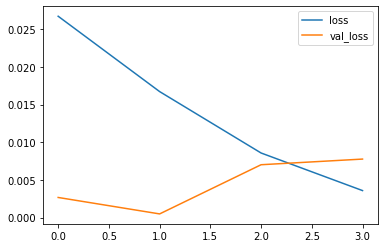

In [26]:
pd.DataFrame(model.history.history).plot()

In [27]:
test_preds = []
batch_ = scaled_train[-12:]
batch = batch_.reshape((1,12,1))

In [28]:
for i in range(len(test)):
    processed = model.predict(batch, verbose=0)[0]
    test_preds.append(processed)
    batch = np.append(batch[:,1:,:], [[processed]], axis=1)

In [29]:
test['Prediction'] = scaler.inverse_transform(test_preds)

/tmp/ipykernel_4853/1632451776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = scaler.inverse_transform(test_preds)


In [30]:
test['Prediction'].values

array([102.12978818, 100.06083184, 102.76423162, 111.01000053,
       121.91369523, 131.94586366, 140.32509565, 145.41679842,
       149.17251804, 147.29285501, 142.3005262 , 131.7734018 ,
       125.09404743, 119.84971414, 119.7985272 , 125.37035444,
       134.71894981, 145.74755866, 156.84149336, 166.79346346,
       174.76292946, 178.6858652 , 177.45751804, 171.0931744 ])

In [38]:
test

,Production,Prediction
DATE,,
2017-10-01,90.4732,102.129788
2017-11-01,77.4378,100.060832
2017-12-01,75.8118,102.764232
2018-01-01,83.4343,111.010001
2018-02-01,99.4899,121.913695
2018-03-01,107.3152,131.945864
2018-04-01,112.4309,140.325096
2018-05-01,110.3544,145.416798
2018-06-01,124.5841,149.172518


In [43]:
scaler  =MinMaxScaler()
scaled_full_data = scaler.fit_transform(df)

In [45]:
forecast = []

periods = 12
length = 12
n_features = 1

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 20ms/step


In [46]:
forecast_data = scaler.inverse_transform(forecast)

In [47]:
forecast_index = pd.date_range(start='2019-10-01',periods=periods,freq='MS')

In [49]:
forecast_df = pd.DataFrame(data=forecast_data,index=forecast_index,
                           columns=['Forecast'])

In [59]:
forecast_df

,Forecast
2019-10-01,97.082924
2019-11-01,95.018783
2019-12-01,96.923798
2020-01-01,103.924626
2020-02-01,113.341781
2020-03-01,124.366693
2020-04-01,132.643113
2020-05-01,139.353388
2020-06-01,144.636593
2020-07-01,142.389564


In [75]:
df = pd.concat([df, forecast_df]).reset_index(drop=True)

<AxesSubplot:>

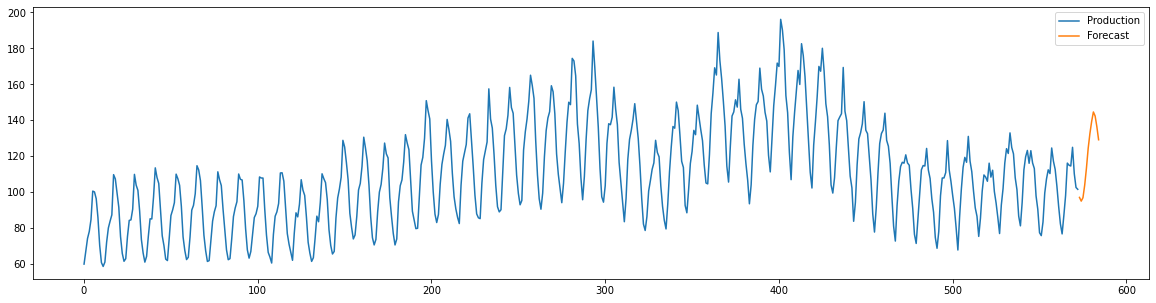

In [76]:
df.plot(figsize=(20,5))

In [31]:

import math

In [32]:
MSE = np.square(np.subtract(test['Production'].values,test['Prediction'].values )).mean() 

In [33]:
RMSE = math.sqrt(MSE)

In [34]:
RMSE

40.078371769238515

In [36]:
a[:2, 1:3]

TypeError: list indices must be integers or slices, not tuple

In [37]:
list = [100, 200]
  
# creating 1-d array
a = np.array(list)
print(a)

[100 200]


In [38]:
a.shape

(2,)

In [39]:
list = [[100], [200], [300]]
  
# creating 1-d array
b = np.array(list)
print(n.shape)

NameError: name 'n' is not defined

In [40]:
c = a*b

In [63]:
c.shape

(3, 2)